<a href="https://colab.research.google.com/github/francesco-source/DeepLearning/blob/main/image_inpainting/Unet_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 2

For the second model I decided to create an U-Net based model, that is a convolutional neural network developed for biomedical image segmentation. The main idea is to supplement a usual contracting network by successive layers, where pooling operations are replaced.

I defined 2 custom block of layers:
1. Residual Convolution Block (RCB), which is compose of two 2d Convolution with residual connection.
2. Residual Convolution with Bottleneck (RCBB), is like with RCB but with a bottleneck in the residual connection.

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
print("new image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))

image range is 0, 255
new image range is 0.0, 1.0


In [4]:
def mask(X,coords):
  x0,y0,x1,y1 = coords
  X[:,x0:x1,y0:y1] = 0
  return X


masked_x_train = mask(np.copy(x_train),(2,16,30,30))
masked_x_test = mask(np.copy(x_test),(2,16,30,30))

In [11]:
def display_history(history):
    mse_training = history.history['loss']

    mse_val = history.history['val_loss']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training/validation')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

In [ ]:
class ResidualConvolutionBlock(tf.keras.layers.Layer):
    def __init__(self, channels):
      super(ResidualConvolutionBlock, self).__init__()
      self.conv1 = tf.keras.layers.Conv2D(channels, (3, 3), padding='same', activation='relu')
      self.conv2 = tf.keras.layers.Conv2D(channels, (3, 3), padding='same', activation='relu')

    def call(self, inputs):
      conv1 = self.conv1(inputs)
      conv2 = self.conv2(conv1)
      output = conv2 + inputs
      return output

class ResidualConvolutionBlockBottleneck(tf.keras.layers.Layer):
    def __init__(self, channels):
      super(ResidualConvolutionBlockBottleneck, self).__init__()
      self.conv1 = tf.keras.layers.Conv2D(channels, (3, 3), padding='same')
      self.conv2 = tf.keras.layers.Conv2D(channels, (3, 3), padding='same')
      self.bottleneck = tf.keras.layers.Conv2D(channels, (1, 1), padding='same')
      self.dropout = tf.keras.layers.Dropout(0.5)

    def call(self, inputs):
      conv1 = self.conv1(inputs)
      conv1 = tf.keras.layers.LeakyReLU()(conv1)

      conv2 = self.conv2(conv1)
      conv2 = tf.keras.layers.LeakyReLU()(conv2)

      output = conv2 + self.bottleneck(inputs)
      output = self.dropout(output)

      return output

class SecondModel(tf.keras.Model):
  def __init__(self):
    super(SecondModel, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')
    self.rcbs1 = [ResidualConvolutionBlock(32), ResidualConvolutionBlock(32), ResidualConvolutionBlock(32), ResidualConvolutionBlock(32)]

    self.downsampling1 = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')
    self.rcbs2 = [ResidualConvolutionBlock(64), ResidualConvolutionBlock(64), ResidualConvolutionBlock(64), ResidualConvolutionBlock(64)]

    self.downsampling2 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')
    self.rcbs3 = [ResidualConvolutionBlock(128), ResidualConvolutionBlock(128), ResidualConvolutionBlock(128), ResidualConvolutionBlock(128)]

    self.downsampling3 = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')
    self.rcbs4 = [ResidualConvolutionBlock(256), ResidualConvolutionBlock(256), ResidualConvolutionBlock(256), ResidualConvolutionBlock(256)]

    self.upsampling1 = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')
    self.upconv1 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')
    self.leakyrelu1 = tf.keras.layers.LeakyReLU()
    self.rcbb1 = ResidualConvolutionBlockBottleneck(128)

    self.upsampling2 = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')
    self.upconv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')
    self.leakyrelu2 = tf.keras.layers.LeakyReLU()
    self.rcbb2 = ResidualConvolutionBlockBottleneck(64)

    self.upsampling3 = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')
    self.upconv3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')
    self.leakyrelu3 = tf.keras.layers.LeakyReLU()
    self.rcbb3 = ResidualConvolutionBlockBottleneck(32)

    self.last_conv = tf.keras.layers.Conv2D(3, (3, 3), padding='same')
  
  def call(self, inputs):
    output1 = self.conv1(inputs)

    for block in self.rcbs1:
      output1 = block(output1)

    output2 = self.downsampling1(output1)

    for block in self.rcbs2:
      output2 = block(output2)

    output3 = self.downsampling2(output2)

    for block in self.rcbs3:
      output3 = block(output3)

    output4 = self.downsampling3(output3)

    for block in self.rcbs4:
      output4 = block(output4)

    output5 = self.upsampling1(output4)
    output5 = self.upconv1(output5)
    output5 = self.leakyrelu1(output5)

    output5 = tf.keras.layers.concatenate([output3, output5])
    output5 = self.rcbb1(output5)

    output5 = self.upsampling2(output5)
    output5 = self.upconv2(output5)
    output5 = self.leakyrelu2(output5)

    output5 = tf.keras.layers.concatenate([output2, output5])
    output5 = self.rcbb2(output5)
    
    output5 = self.upsampling3(output5)
    output5 = self.upconv3(output5)
    output5 = self.leakyrelu3(output5)

    output5 = tf.keras.layers.concatenate([output1, output5])
    output5 = self.rcbb3(output5)

    output5 = self.last_conv(output5)
    output5 = tf.keras.layers.add([inputs, output5])
  
    return output5

second_model = SecondModel()
second_model.build(input_shape=(None, 32, 32, 3))
second_model.summary()


In [8]:
import tensorflow as tf

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.1, staircase=True
)

second_model_callback = tf.keras.callbacks.EarlyStopping(patience=15)


second_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler), loss="mse")

second_history = second_model.fit(
    masked_x_train,
    x_train,
    batch_size=300,
    shuffle=True,
    validation_split=0.1,
    epochs=20,
    callbacks=[second_model_callback]
)


Epoch 1/20
150/150 [==============================] - 69s 343ms/step - loss: 0.0512 - val_loss: 0.0103
Epoch 2/20
150/150 [==============================] - 50s 335ms/step - loss: 0.0119 - val_loss: 0.0096
Epoch 3/20
150/150 [==============================] - 51s 337ms/step - loss: 0.0112 - val_loss: 0.0095
Epoch 4/20
150/150 [==============================] - 52s 344ms/step - loss: 0.0109 - val_loss: 0.0092
Epoch 5/20
150/150 [==============================] - 51s 337ms/step - loss: 0.0107 - val_loss: 0.0093
Epoch 6/20
150/150 [==============================] - 51s 337ms/step - loss: 0.0105 - val_loss: 0.0090
Epoch 7/20
150/150 [==============================] - 51s 337ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 8/20
150/150 [==============================] - 51s 337ms/step - loss: 0.0101 - val_loss: 0.0089
Epoch 9/20
150/150 [==============================] - 51s 337ms/step - loss: 0.0098 - val_loss: 0.0087
Epoch 10/20
150/150 [==============================] - 52s 345ms/step - l

In [9]:
eval_output3 = second_model.evaluate(masked_x_test, x_test, return_dict=True)

313/313 [==============================] - 5s 15ms/step - loss: 0.0091


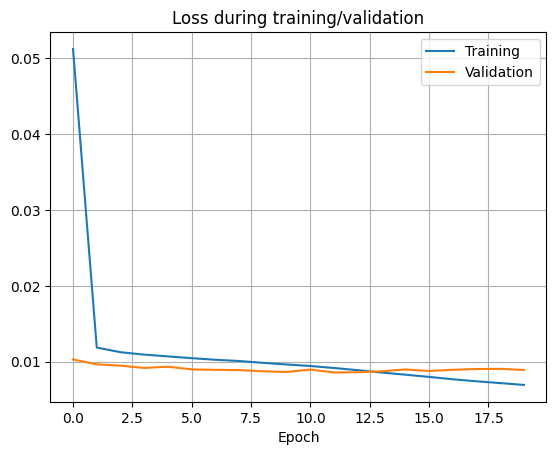

In [12]:
display_history(second_history)